# Загрузка датасета COCO и кода COCO API

In [1]:
# ! mkdir datasets/coco

# !cd datasets/coco && wget http://images.cocodataset.org/zips/train2017.zip 
# !cd datasets/coco && wget http://images.cocodataset.org/zips/val2017.zip 
# !cd datasets/coco && wget http://images.cocodataset.org/annotations/annotations_trainval2017.zip 
  
# !cd datasets/coco && unzip -q train2017.zip
# !cd datasets/coco && unzip -q val2017.zip
# !cd datasets/coco && unzip -q annotations_trainval2017.zip

# !cd datasets/coco && git clone https://github.com/cocodataset/cocoapi
# !cd datasets/coco/cocoapi/PythonAPI && make

In [2]:
import os
import skimage.io as io
import numpy as np
import matplotlib.pyplot as plt

In [3]:
import tensorflow as tf
print('TensorFlow version:', tf.__version__)

TensorFlow version: 2.12.0


# Импорт библиотеки COCO API

In [4]:
COCO_ROOT = './datasets/coco/'

import sys
sys.path.insert(0, os.path.join(COCO_ROOT, 'cocoapi/PythonAPI'))
from pycocotools.coco import COCO

# Класс Dataset

Этот класс конструирует экземпляры tf.data.Dataset и является универсальным для сегментации (подходит для использования с различными
датасетами)
Однако, это абстрактный класс, в котором не реализован метод чтения датасета с диска, так как этот метод может отличаться для разных
датасетов.

In [5]:
class Dataset():

    def crop_images(self, img, inp_size, random_crop=False):
        shape = tf.shape(img)
        pad = (
            [0, tf.maximum(inp_size - shape[0], 0)],
            [0, tf.maximum(inp_size - shape[1], 0)],
            [0, 0],
        )
        img = tf.pad(img, pad)

        if random_crop:
            img = tf.image.random_crop(img, (inp_size, inp_size, shape[2]))
        else: # central crop
            shape = tf.shape(img)
            ho = (shape[0] - inp_size) // 2
            wo = (shape[1] - inp_size) // 2
            img = img[ho:ho+inp_size, wo:wo+inp_size, :]

        return img

    def train_dataset(self, batch_size, epochs, inp_size):

        def item_to_images(item):
            random_crop = True
            img_combined = tf.py_function(self.read_images, [item], tf.uint8)
            img_combined = self.crop_images(img_combined, inp_size, random_crop)

            img = tf.cast(img_combined[...,:3], tf.float32) / np.float32(255.)
            mask_class = tf.cast(img_combined[...,3:4], tf.float32)
            return img, mask_class

        dataset = tf.data.Dataset.from_tensor_slices(self.img_list)
        dataset = dataset.shuffle(buffer_size=len(self.img_list))
        dataset = dataset.map(item_to_images)
        dataset = dataset.repeat(epochs)
        dataset = dataset.batch(batch_size, drop_remainder=True)

        return dataset

    def val_dataset(self, batch_size, inp_size):

        def item_to_images(item):
            random_crop = False
            img_combined = tf.py_function(self.read_images, [item], tf.uint8)
            img_combined = self.crop_images(img_combined, inp_size, random_crop)

            img = tf.cast(img_combined[...,:3], tf.float32) / np.float32(255.)
            mask_class = tf.cast(img_combined[...,3:4], tf.float32)
            return img, mask_class

        dataset = tf.data.Dataset.from_tensor_slices(self.img_list)
        dataset = dataset.map(item_to_images)
        dataset = dataset.batch(batch_size, drop_remainder=True)

        return dataset

# Класс COCO_Datasetm

In [6]:
class COCO_Dataset(Dataset):

    def __init__(self, sublist):
        ann_file_fpath = os.path.join(COCO_ROOT, 'annotations', 'instances_'+sublist+'2017.json')
        self.coco = COCO(ann_file_fpath)
        self.cat_ids = self.coco.getCatIds(catNms=['person'])
        self.img_list = self.coco.getImgIds(catIds=self.cat_ids)

    def read_images(self, img_id):
        img_id = int(img_id.numpy())
        img_data = self.coco.loadImgs(img_id)[0]
        img_fname = '/'.join(img_data['coco_url'].split('/')[-2:])

        img = io.imread(os.path.join(COCO_ROOT, img_fname))
        if len(img.shape) == 2:
            img = np.tile(img[..., None], (1, 1, 3))

        ann_ids = self.coco.getAnnIds(imgIds=img_data['id'], catIds=self.cat_ids, iscrowd=None)
        anns = self.coco.loadAnns(ann_ids)
        mask_class = np.zeros((img.shape[0], img.shape[1]), dtype=np.uint8)
        for i in range(len(anns)):
            mask_class += self.coco.annToMask(anns[i])
        mask_class = (mask_class > 0).astype(np.uint8)

        img_combined = np.concatenate([img, mask_class[..., None]], axis=2)

        return img_combined

# Создание обучающего и валидационного датасета

In [7]:
INP_SIZE = 256
NUM_EPOCHS = 5
BATCH_SIZE = 32
LEARNING_RATE = 0.0005 # первоначально было 0.0001
EXP_NAME = 'U-Net'

In [8]:
COCO_dataset_train = COCO_Dataset('train')
COCO_dataset_val = COCO_Dataset('val')

train_ds = COCO_dataset_train.train_dataset(batch_size=BATCH_SIZE, epochs=1, inp_size=INP_SIZE)
val_ds = COCO_dataset_val.val_dataset(batch_size=BATCH_SIZE, inp_size=INP_SIZE)

loading annotations into memory...
Done (t=6.60s)
creating index...
index created!
loading annotations into memory...
Done (t=1.15s)
creating index...
index created!
Metal device set to: Apple M2


In [9]:
train_ds, val_ds, len(train_ds), len(val_ds)

(<_BatchDataset element_spec=(TensorSpec(shape=(32, 256, 256, None), dtype=tf.float32, name=None), TensorSpec(shape=(32, 256, 256, None), dtype=tf.float32, name=None))>,
 <_BatchDataset element_spec=(TensorSpec(shape=(32, None, None, None), dtype=tf.float32, name=None), TensorSpec(shape=(32, None, None, None), dtype=tf.float32, name=None))>,
 2003,
 84)

# Визуализция датасета

2023-05-08 09:23:55.558375: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


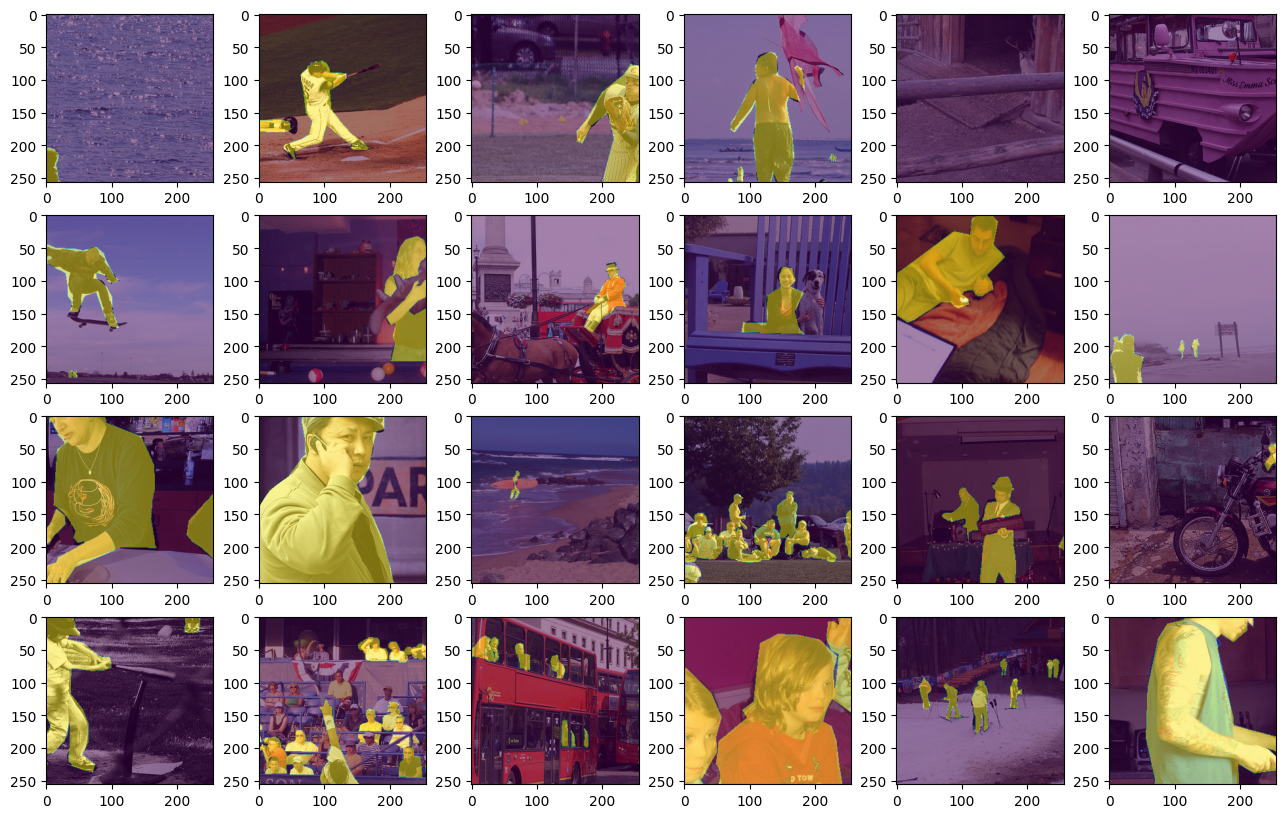

In [10]:
image, mask = next(iter(train_ds.take(24)))

fig = plt.figure(figsize=(16, 10))
for i in range(24):
    ax = fig.add_subplot(4, 6, i+1)
    ax.imshow(image[i])
    ax.imshow(mask[i, ..., 0], alpha=0.5)
plt.show()


# Создание U-модели

In [11]:
# U-Net
def build_model():
    x = tf.keras.layers.Input((256, 256, 3))
    
    out = tf.keras.layers.Conv2D(64, (3, 3), padding='same', activation='relu')(x)
    out1 = tf.keras.layers.Conv2D(64, (3, 3), padding='same', activation='relu')(out)
    out = tf.keras.layers.MaxPool2D((2, 2))(out1)

    out = tf.keras.layers.Conv2D(64, (3, 3), padding='same', activation='relu')(out)
    out2 = tf.keras.layers.Conv2D(128, (3, 3), padding='same', activation='relu')(out)
    out = tf.keras.layers.MaxPool2D((2, 2))(out2)

    out = tf.keras.layers.Conv2D(256, (3, 3), padding='same', activation='relu')(out)
    out3 = tf.keras.layers.Conv2D(256, (3, 3), padding='same', activation='relu')(out)
    out = tf.keras.layers.MaxPool2D((2, 2))(out3)

    out = tf.keras.layers.Conv2D(512, (3, 3), padding='same', activation='relu')(out)
    out4 = tf.keras.layers.Conv2D(512, (3, 3), padding='same', activation='relu')(out)
    out = tf.keras.layers.MaxPool2D((2, 2))(out4)

    out = tf.keras.layers.Conv2D(1024, (3, 3), padding='same', activation='relu')(out)
    out = tf.keras.layers.Conv2D(1024, (3, 3), padding='same', activation='relu')(out)

    out = tf.keras.layers.Conv2DTranspose(512, (3, 3), strides=(2, 2), padding='same', activation='relu')(out)
    out = tf.concat([out4, out], axis=3)

    out = tf.keras.layers.Conv2D(512, (3, 3), padding='same', activation='relu')(out)
    out = tf.keras.layers.Conv2D(512, (3, 3), padding='same', activation='relu')(out)

    out = tf.keras.layers.Conv2DTranspose(256, (3, 3), strides=(2, 2), padding='same', activation='relu')(out)
    out = tf.concat([out3, out], axis=3)

    out = tf.keras.layers.Conv2D(256, (3, 3), padding='same', activation='relu')(out)
    out = tf.keras.layers.Conv2D(256, (3, 3), padding='same', activation='relu')(out)

    out = tf.keras.layers.Conv2DTranspose(128, (3, 3), strides=(2, 2), padding='same', activation='relu')(out)
    out = tf.concat([out2, out], axis=3)

    out = tf.keras.layers.Conv2D(128, (3, 3), padding='same', activation='relu')(out)
    out = tf.keras.layers.Conv2D(128, (3, 3), padding='same', activation='relu')(out)

    out = tf.keras.layers.Conv2DTranspose(64, (3, 3), strides=(2, 2), padding='same', activation='relu')(out)
    out = tf.concat([out1, out], axis=3)

    out = tf.keras.layers.Conv2D(64, (3, 3), padding='same', activation='relu')(out)
    out = tf.keras.layers.Conv2D(64, (3, 3), padding='same', activation='relu')(out)
    out = tf.keras.layers.Conv2D(1, (3, 3), padding='same', activation='sigmoid')(out)

    return tf.keras.Model(inputs=x, outputs=out)

model = build_model()

# Визуализация модели

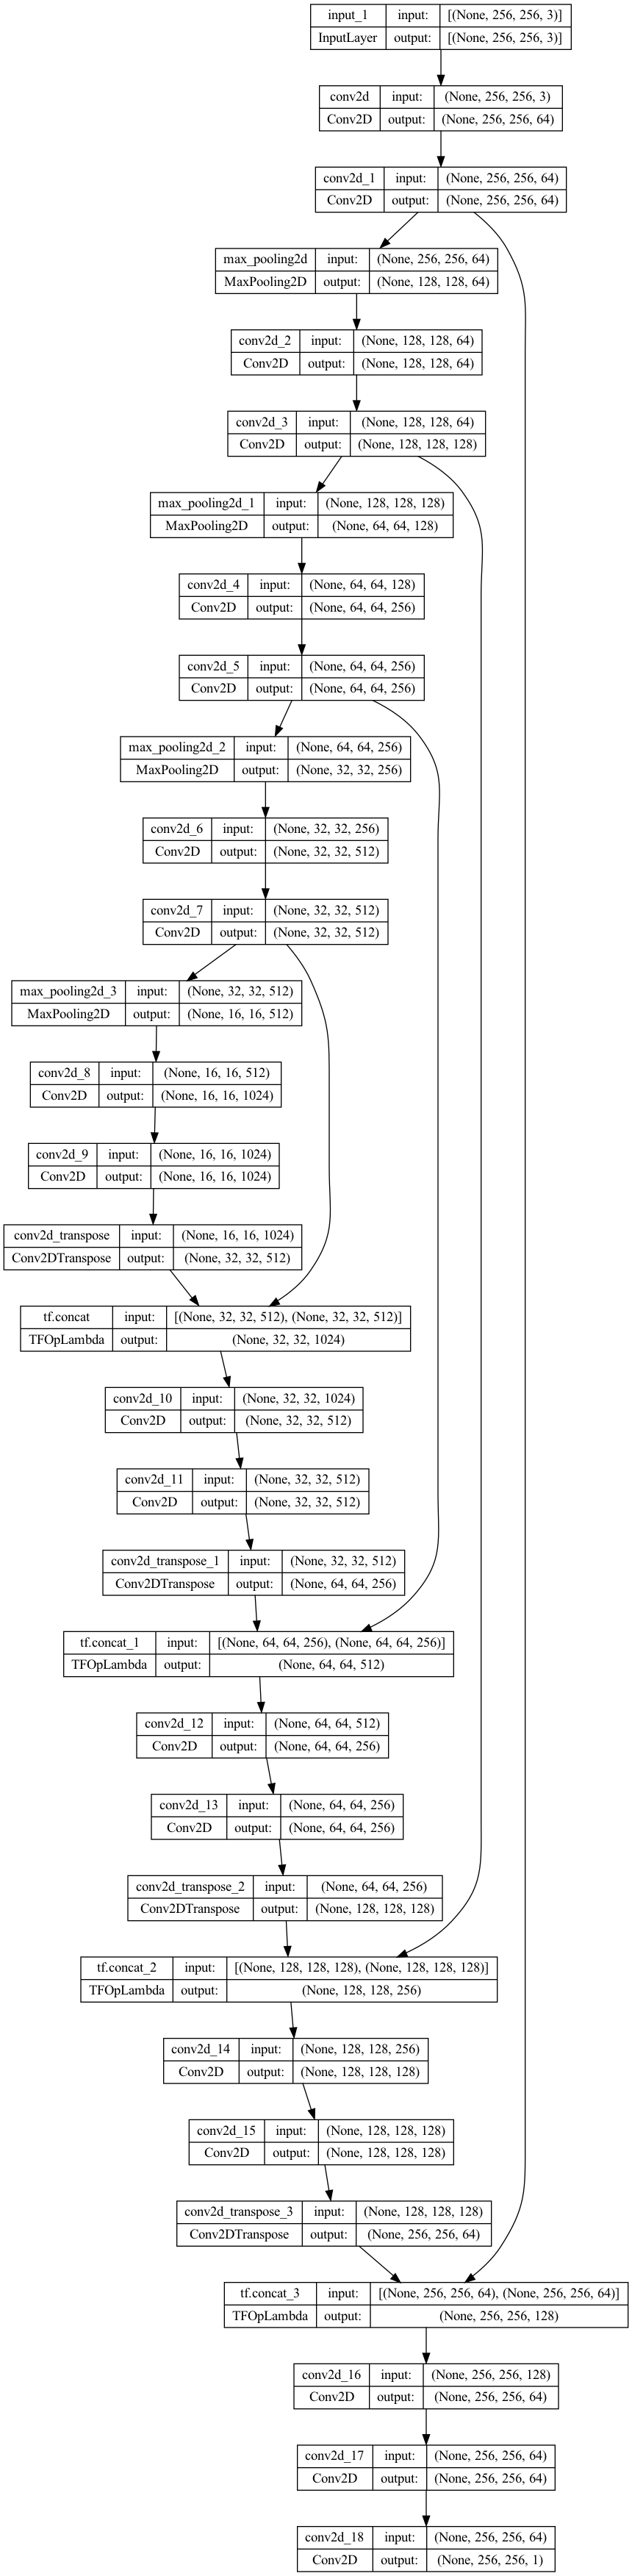

In [12]:
# draw model
tf.keras.utils.plot_model(model, show_shapes=True)

In [13]:
optimizer = tf.keras.optimizers.legacy.Adam(learning_rate=LEARNING_RATE)

model.compile(optimizer=optimizer,
              loss='BinaryCrossentropy', 
              metrics=['accuracy'])



tensorboard_callback = tf.keras.callbacks.TensorBoard(
    log_dir='logs/'+EXP_NAME, 
    write_graph=False, update_freq=100, profile_batch=0)

# Checkpoints

In [14]:
checkpoint_path = 'models/'

ckpt = tf.train.Checkpoint(
    model=model,
    optimizer=optimizer
)
ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)

if ckpt_manager.latest_checkpoint:
    ckpt.restore(ckpt_manager.latest_checkpoint)
    print ('Latest checkpoint restored!!')

In [ ]:
%%time

history = model.fit(train_ds, 
                          batch_size=BATCH_SIZE, 
                          epochs=NUM_EPOCHS, 
                          validation_data=val_ds, 
                          callbacks=[tensorboard_callback]
                          )

ckpt_manager.save()

Epoch 1/5
  30/2003 [..............................] - ETA: 2:49:54 - loss: 0.5264 - accuracy: 0.7998

In [ ]:
%%time
score_train = model.evaluate(train_ds, verbose=0)
score_test = model.evaluate(test_ds, verbose=0)

# Результат

In [ ]:
result = pd.DataFrame((score_train[1], score_test[1], score_train[0], score_test[0])).T
result.columns=['train_accuracy', 'test_accuracy', 'train_loss', 'test_loss']
result['model'] = 'U-Net'

In [ ]:
result

In [ ]:
plot_model(history)